In [1]:
# imports 

# make notebook span full width of window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] + "Dragonfly44_SFH/" # hack, but works

import numpy as np

from figure_style import *
from copy import deepcopy


In [2]:
path_data = path_base+ "data/"
obs_file = path_data+"DF44/obs_phot_specKCWI_sigma110.h5"

import h5py
from sedpy.observate import load_filters

obs = {}
with h5py.File(obs_file,'r') as hfile:
    for key in hfile.keys():
        obs[key] = np.copy( hfile[key] )        
filternames = obs['filternames'].tolist() 
obs["filters"] = load_filters( filternames )

zobs = float(obs['Redshift'])

In [5]:
from Dragonfly44_SFH.utils.build_sps_model import build_model_sps, build_sps_sps

sps = build_sps_sps()

model = build_model_sps( zobs )

In [6]:
obs_mock = dict( wavelength=None, spectrum=None, unc=None, mask=None )
# for key in ['maggies','filternames','maggies_unc','filters','phot_wave']:
#     obs_mock[key] = obs[key]
    
filternames = obs['filternames'].tolist() + ["jwst_f560w","jwst_f770w"]
N = len(filternames)
phot_filters = load_filters( filternames )
phot_wave = np.array([ f.wave_effective for f in phot_filters ])

obs_mock["filternames"] = filternames
obs_mock["filters"]     = np.copy( phot_filters )
obs_mock["phot_wave"]   = np.copy( phot_wave )

obs_mock['maggies'] = np.zeros( N )
obs_mock['maggies_unc'] = np.zeros( N )
obs_mock['phot_mask'] = np.zeros( N )
    
wave = sps.wavelengths * (1.+zobs )    

In [14]:
theta1 = model.initial_theta
theta1[ model.theta_index['dust2'] ] = 0.001
theta1[ model.theta_index['logzsol'] ] = -1.26
theta1[ model.theta_index['tage'] ] = 10.6
print( theta1 )
sed1,  phot1, _ = model.predict( theta1, obs=obs_mock, sps=sps)
spec1, _, _ = model.predict( theta1, obs=obs,  sps=sps)

theta2 = deepcopy( theta1 )
theta2[ model.theta_index['tage'] ] = 13.4
print( theta2 )
sed2,  phot2, _ = model.predict( theta2, obs=obs_mock, sps=sps)
spec2, _, _ = model.predict( theta2, obs=obs,  sps=sps)

theta3 = deepcopy( theta1 )
theta3[ model.theta_index['dust2'] ] = 0.2
print( theta3 )
sed3,  phot3, _ = model.predict( theta3, obs=obs_mock, sps=sps)
spec3, _, _ = model.predict( theta3, obs=obs,  sps=sps)

[ 3.16227766e+08 -1.26000000e+00  1.00000000e-03  1.06000000e+01]
[ 3.16227766e+08 -1.26000000e+00  1.00000000e-03  1.34000000e+01]
[ 3.16227766e+08 -1.26000000e+00  2.00000000e-01  1.06000000e+01]


In [15]:
col1, col2, col3 = '#fe1f69','#674290','#bbbc5f'
col3 = '#37E36C'

col1 = '0.5'
col2 = 'm'
col3 = 'c'

params1 = dict( color=col1, lw=1, ls='-')
params2 = dict( color=col2, lw=1., dashes=(4,2))
params3 = dict( color=col3, lw=2, ls='-')

In [19]:
# jwst data

maggies_jwst_old = phot2[-2:]
maggies_jwst_dusty = phot3[-2:]
snr = 5.

obs_fake_old = deepcopy(obs)
obs_fake_dusty = deepcopy(obs)

filternames = obs['filternames'].tolist() + ["jwst_f560w","jwst_f770w"]
phot_filters = load_filters( filternames )
phot_wave = np.array([ f.wave_effective for f in phot_filters ])

for obs_fake, maggies_fake in [ [obs_fake_old, maggies_jwst_old], [obs_fake_dusty, maggies_jwst_dusty] ]:

    obs_fake["filternames"] = filternames
    obs_fake["filters"]     = np.copy( phot_filters )
    obs_fake["phot_wave"]   = np.copy( phot_wave )

    maggies_unc_fake = maggies_fake/snr

    obs_fake['maggies'] = np.append( obs['maggies'], maggies_fake )
    obs_fake['maggies_unc'] = np.append( obs['maggies_unc'], maggies_unc_fake )
    obs_fake['phot_mask'] = np.ones( len(filternames), dtype=bool )


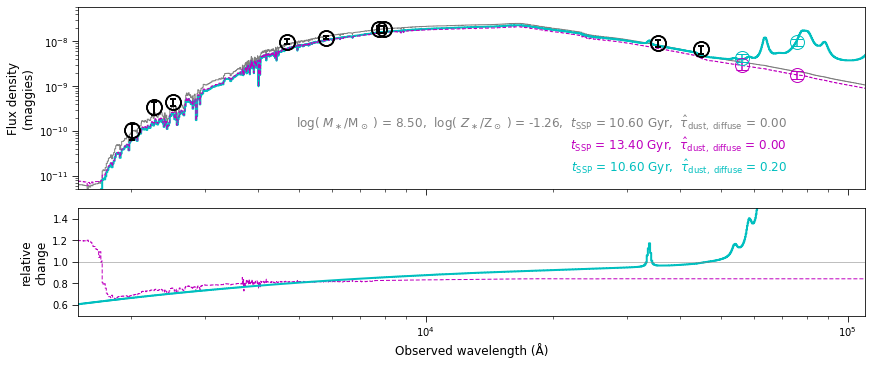

In [20]:
fs = 12
fig, axes = plt.subplots(2,1,figsize=(fig_width_two, textheight*0.3), gridspec_kw={"height_ratios":[1.7,1]}, sharex=False)
ax1,ax1b = axes.flatten()

if True: # SED 
    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=15, mew=1.5) 

    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=15, mew=1.5) 

    x,y,ey = [ np.copy( obs[key] ) for key in ['phot_wave','maggies','maggies_unc']]
    ax1.errorbar( x, y, yerr=ey, marker='o', mfc='None',mec='k', color='k', capsize=3, fmt=' ', ms=15, mew=1.5) 
    
    
if True: # models
    
    
    for (spec,sed,params) in [  [spec1, sed1, params1], 
                                [spec3, sed3, params3],
                                [spec2, sed2, params2], 
                           ]:
        ax1.step( wave, sed, where='post', zorder=0, **params )
        
    ax1b.axhline(1, color=col1, lw=0.5 )
    
    for (rspec,rsed,params) in [ [spec2/spec1, sed2/sed1, params2], 
                                 [spec3/spec1, sed3/sed1, params3],
                           ]:
        ax1b.step( wave, rsed, where='post', zorder=0, **params )
           
for oobs,params in [ [obs_fake_old,   params2],\
                     [obs_fake_dusty, params3], \
                   ]:
    
    ax1.errorbar( oobs['phot_wave'][-2:], oobs['maggies'][-2:], yerr=oobs['maggies_unc'][-2:], \
                fmt=' ', color=params['color'], marker='o', ms=14, mec=params['color'], mfc='None', capsize=6 )
            
            
if True: # model param labels 
    fmt = "{{0:{0}}}".format(".2f").format 
    label_params = [r"$t_\mathrm{SSP}$",\
                    r"$\log(~M_\ast/\mathrm{M}_\odot~)$",\
                    r"$\log(~Z_\ast/\mathrm{Z}_\odot~)$", \
                    r"$\hat{\tau}_\mathrm{dust,~diffuse}$"]
    label1_tofill =  "{1} = {5},  {2} = {6},  {0} = {4} Gyr,  {3} = {7}"
    label2_tofill =  "{0} = {4} Gyr,  {3} = {7}"
    label1 = label1_tofill.format( *label_params, 
                                   fmt(theta1[3]), fmt(np.log10(theta1[0])), fmt(theta1[1]), fmt(theta1[2]) )
    ax1.annotate( label1, xy=(0,0), xytext=(0.9,0.34), ha='right', xycoords='axes fraction', fontsize=12, color=col1)
    label2 = label2_tofill.format( *label_params, 
                                   fmt(theta2[3]), fmt(np.log10(theta2[0])), fmt(theta2[1]), fmt(theta2[2]) )
    ax1.annotate( label2, xy=(0,0), xytext=(0.9,0.22), ha='right', xycoords='axes fraction', fontsize=12, color=col2)
    label2 = label2_tofill.format( *label_params, 
                                   fmt(theta3[3]), fmt(np.log10(theta3[0])), fmt(theta3[1]), fmt(theta3[2]) )
    ax1.annotate( label2, xy=(0,0), xytext=(0.9,0.1), ha='right', xycoords='axes fraction', fontsize=12, color=col3)
    
if True: # plot adjustments    

    ax1.set( xscale='log', yscale='log', xlim=(1.5e3, 1.1e5), ylim=(5e-12,6e-8), xticklabels=[] )
    ax1.set_ylabel('Flux density\n(maggies)', fontsize=fs)    
    ax1b.set( xscale='log', yscale='linear', xlim=ax1.get_xlim(), ylim=(5e-1,1.5) )
    ax1b.set_xlabel(u"Observed wavelength (\u00c5)", fontsize=fs)   
    ax1b.set_ylabel(u"relative\nchange", fontsize=fs)  
    
    for ax in axes:
        ax.tick_params(direction='out', length=6, which='major')
        ax.tick_params(direction='out', length=3, which='minor')

fig.subplots_adjust( hspace=0.13)
plt.savefig('figures/figC1.pdf', **saveparams )
plt.show()